In [20]:
import os
import pandas as pd
from sklearn.metrics import mean_absolute_error
base="D:\Projects\Order_counting\data"
def prediction(image_path):
    image = cv2.imread(image_path)
    (result, weights) = HOGCV.detectMultiScale(image,winStride=(1,1))
    result = non_max_suppression(result, probs=None, overlapThresh=0.65)
    return result.shape[0]
def people_prediction(img_path):
    label=img_path.split('.')[0].split('_')[1]
    return label,prediction(os.path.join(base,img_path))
#print(os.listdir("D:\Projects\Order_counting\data"))
a=os.listdir(base)
itog=[]
for i in a:
    itog.append(people_prediction(i))
result=pd.DataFrame(itog,columns=['label','prediction'])
result['label']=result['label'].astype(int)
print(f"""средняя ошибка: {mean_absolute_error(result['label'],result['prediction'])}
максимальная ошибка: {(result['label']-result['prediction']).max()}
процент верно предсказанных: {(result['label']==result['prediction']).mean()}""")

NameError: name 'predict' is not defined

In [28]:
%%time
import numpy as np
import cv2
import imutils 
from imutils.object_detection  import non_max_suppression 
HOGCV = cv2.HOGDescriptor()
HOGCV.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
def detector(image):
    '''
    @image is a numpy array
    '''

#    image = imutils.resize(image, width=min(400, image.shape[1]))
    clone = image.copy()

    (rects, weights) = HOGCV.detectMultiScale(image,winStride=(1,1))

    # Applies non-max supression from imutils package to kick-off overlapped
    # boxes
    rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in rects])
    result = non_max_suppression(rects, probs=None, overlapThresh=0.65)

    return rects
def localDetect(image_path):
    result = []
    image = cv2.imread(image_path)
    
    image=image[:310,180:420]
    image[:160,:80]=0
    
    if len(image) <= 0:
        print("[ERROR] could not read your local image")
        return result
    print("[INFO] Detecting people")
    result = detector(image)

    # shows the result
    for (xA, yA, xB, yB) in result:
        cv2.rectangle(image, (xA, yA), (xB, yB), (0, 255, 0), 2)

    cv2.imshow("result", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return (result, image)
def prediction(image_path):
    image = cv2.imread(image_path)
    (result, weights) = HOGCV.detectMultiScale(image,winStride=(1,1))
    result = non_max_suppression(result, probs=None, overlapThresh=0.65)
    return result.shape[0]

# image = cv2.imread(r"D:\Projects\Order_counting\data\627image_5.jpg")
# image=image[:310,180:420]
# image[:160,:80]=0
# cv2.imshow("result",image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
localDetect(r"D:\Projects\Order_counting\data\616image_8.jpg")

[INFO] Detecting people


error: OpenCV(4.1.1) C:\projects\opencv-python\opencv\modules\objdetect\src\cascadedetect.cpp:1689: error: (-215:Assertion failed) !empty() in function 'cv::CascadeClassifier::detectMultiScale'


In [47]:
import tensorflow as tf
import numpy as np
import os
import cv2
from matplotlib import pyplot as plt
from PIL import Image
#from utils import label_map_util
PATH_TO_LABELS = "D:\Projects\Order counting\mscoco_label_map.pbtxt"
PATH_TO_FROZEN_GRAPH =r'D:\Projects\Order_counting\faster_rcnn_inception_v2_coco_2018_01_28\frozen_inference_graph.pb'
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                  'num_detections', 'detection_boxes', 'detection_scores',
                  'detection_classes', 'detection_masks'
              ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[1], image.shape[2])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

          # Run inference
            output_dict = sess.run(tensor_dict,
                                 feed_dict={image_tensor: image})

          # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
              'detection_classes'][0].astype(np.int64)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

def prediction(image_path):
    image = Image.open(image_path)
    image_np = load_image_into_numpy_array(image)
    image_np_expanded = np.expand_dims(image_np, axis=0)
    output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
    itog=0
    for i in range(100):
        if output_dict['detection_scores'][i]<0.5:
            break
        if output_dict['detection_classes'][i]==1:
            itog+=1
    return itog
from imutils.object_detection  import non_max_suppression 
def prediction(image_path):
    image = Image.open(image_path)
    image_np = load_image_into_numpy_array(image)
    image_np_expanded = np.expand_dims(image_np, axis=0)
    output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
    itog=[]
    for i in range(100):
        if output_dict['detection_scores'][i]<0.5:
            break
        if output_dict['detection_classes'][i]==1:
            itog.append(output_dict['detection_boxes'][i])
    return len(non_max_suppression(np.asarray(itog),overlapThresh=0.8))
prediction(r"D:\Projects\Order_counting\data_3\624image_4_im1_tf7.jpg")



4

In [6]:
%%time
from imageai.Detection import ObjectDetection
model_path=r"D:\Projects\Order_counting\imageai\yolo.h5"
input_path=r"D:\Projects\Order_counting\data\615image_7.jpg"
output_path=r"D:\Projects\Order_counting\test.jpg"
detector = ObjectDetection()
detector.setModelTypeAsYOLOv3()
detector.setModelPath(model_path)
detector.loadModel()
def prediction(image_path):
    image = cv2.imread(image_path)
    
    detection = detector.detectObjectsFromImage(input_image=image,input_type='array',output_type='array')
    itog=0
    for eachItem in detection[1]:
        if eachItem['name']=='person' and eachItem['percentage_probability']>50:
            itog+=1
    return itog
#prediction(r"D:\Projects\Order_counting\data\3image_33.jpg")
image = cv2.imread(r"D:\Projects\Order_counting\147image_.jpg")
#image=image[:310,180:420]
#image[:160,:80]=0
detection = detector.detectObjectsFromImage(input_image=image,input_type='array',output_type='array',thread_safe=True)
#detection
cv2.imshow("result", detection[0])
cv2.waitKey(0)
cv2.destroyAllWindows()

Wall time: 36.8 s


In [36]:
%%time
#Итоговый поиск гистограммы
import os
import pandas as pd
import cv2
import time
import numpy as np
from sklearn.metrics import mean_absolute_error
import imutils 
from imutils.object_detection  import non_max_suppression 
HOGCV = cv2.HOGDescriptor()
HOGCV.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
base="D:\Projects\Order_counting\data"
def prediction(image_path):
    image = cv2.imread(image_path)
    image=image[:310,180:420]
    image[:160,:80]=0
    (result, weights) = HOGCV.detectMultiScale(image,winStride=(1,1),scale=1.01)
    result = non_max_suppression(result, probs=None, overlapThresh=0.65)
    try:
        a=result.shape[0]
    except AttributeError:
        a=0
    return a
def people_prediction(img_path):
    label=img_path.split('.')[0].split('_')[1]
    start_time=time.time()
    return label,prediction(os.path.join(base,img_path)),time.time()-start_time
#print(os.listdir("D:\Projects\Order_counting\data"))
a=os.listdir(base)
itog=[]
for i in a:
    itog.append(people_prediction(i))
result=pd.DataFrame(itog,columns=['label','prediction','times'])
result['label']=result['label'].astype(int)
print(f"""средняя ошибка: {mean_absolute_error(result['label'],result['prediction'])}
время на одну картинку: {result['times'].mean()}
максимальная ошибка: {(result['label']-result['prediction']).max()}
минимальная ошибка: {(result['label']-result['prediction']).min()}
средняя ошибка при большой очереди>4 : {mean_absolute_error(result['label'].loc[result['label']>4],result['prediction'].loc[result['label']>4])}
процент верно предсказанных: {(result['label']==result['prediction']).mean()}""")

средняя ошибка: 1.898989898989899
время на одну картинку: 0.519245881022829
максимальная ошибка: 8
минимальная ошибка: -1
средняя ошибка при большой очереди>4 : 4.37037037037037
процент верно предсказанных: 0.18181818181818182
Wall time: 1min 42s


In [4]:
%%time
#Итоговый поиск imageai
import os
import pandas as pd
import cv2
import time
import numpy as np
from sklearn.metrics import mean_absolute_error
import imutils 
from imutils.object_detection  import non_max_suppression 
from imageai.Detection import ObjectDetection
from tqdm import tqdm_notebook
model_path=r"D:\Projects\Order_counting\imageai\yolo.h5"
base="D:\Projects\Order_counting\data"
#input_path=r"D:\Projects\Order_counting\data\2image_17.jpg"
#output_path=r"D:\Projects\Order_counting\data\test.jpg"
detector = ObjectDetection()
custom = detector.CustomObjects(person=True)
detector.setModelTypeAsYOLOv3()
detector.setModelPath(model_path)
detector.loadModel()
def prediction(image_path):
    image = cv2.imread(image_path)
    image=image[40:310,180:420]
    image[:160,:80]=0
    detection = detector.detectObjectsFromImage(input_image=image,input_type='array',output_type='array',thread_safe=True)
    itog=0
    for eachItem in detection[1]:
        if eachItem['name']=='person' and eachItem['percentage_probability']>10:
            itog+=1
    return itog
def people_prediction(img_path):
    label=img_path.split('.')[0].split('_')[1]
    start_time=time.time()
    return img_path,label,prediction(os.path.join(base,img_path)),time.time()-start_time
#print(os.listdir("D:\Projects\Order_counting\data"))
a=os.listdir(base)
itog=[]
for i in tqdm_notebook(a):
    itog.append(people_prediction(i))
result=pd.DataFrame(itog,columns=['name','label','prediction','times'])
result['label']=result['label'].astype(int)
print(f"""средняя ошибка: {mean_absolute_error(result['label'],result['prediction'])}
время на одну картинку: {result['times'].mean()}
максимальная ошибка: {(result['label']-result['prediction']).max()}
минимальная ошибка: {(result['label']-result['prediction']).min()}
средняя ошибка при большой очереди>4 : {mean_absolute_error(result['label'].loc[result['label']>4],result['prediction'].loc[result['label']>4])}
процент верно предсказанных: {(result['label']==result['prediction']).mean()}""")


средняя ошибка: 0.9393939393939394
время на одну картинку: 0.34745252252829195
максимальная ошибка: 6
минимальная ошибка: -3
средняя ошибка при большой очереди>4 : 2.5185185185185186
процент верно предсказанных: 0.41919191919191917
Wall time: 1min 19s


In [8]:
%%time
#Итоговый поиск tensorflow
import os
import pandas as pd
import cv2
import time
import numpy as np
from sklearn.metrics import mean_absolute_error
import imutils 
import tensorflow as tf
from imutils.object_detection  import non_max_suppression 
from imageai.Detection import ObjectDetection
from tqdm import tqdm_notebook
PATH_TO_LABELS = "D:\Projects\Order counting\mscoco_label_map.pbtxt"
base="D:\Projects\Order_counting\data"
PATH_TO_FROZEN_GRAPH =r'D:\Projects\Order_counting\rfcn\frozen_inference_graph.pb'
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                  'num_detections', 'detection_boxes', 'detection_scores',
                  'detection_classes', 'detection_masks'
              ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[1], image.shape[2])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

          # Run inference
            output_dict = sess.run(tensor_dict,
                                 feed_dict={image_tensor: image})

          # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
              'detection_classes'][0].astype(np.int64)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict  

def prediction(image_path):
    image = cv2.imread(image_path)
    image=image[:310,180:420]
    image[:160,:80]=0
    image_np_expanded = np.expand_dims(image, axis=0)
    output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
    itog=[]
    for i in range(100):
        if output_dict['detection_scores'][i]<0.5:
            break
        if output_dict['detection_classes'][i]==1:
            itog.append(output_dict['detection_boxes'][i])
    return len(non_max_suppression(np.asarray(itog),overlapThresh=1))
def people_prediction(img_path):
    label=img_path.split('.')[0].split('_')[1]
    start_time=time.time()
    return img_path,label,prediction(os.path.join(base,img_path)),time.time()-start_time
#print(os.listdir("D:\Projects\Order_counting\data"))
a=os.listdir(base)
itog=[]
for i in tqdm_notebook(a):
    itog.append(people_prediction(i))
result=pd.DataFrame(itog,columns=['name','label','prediction','times'])
result['label']=result['label'].astype(int)
print(f"""средняя ошибка: {mean_absolute_error(result['label'],result['prediction'])}
время на одну картинку: {result['times'].mean()}
максимальная ошибка: {(result['label']-result['prediction']).max()}
минимальная ошибка: {(result['label']-result['prediction']).min()}
средняя ошибка при большой очереди>4 : {mean_absolute_error(result['label'].loc[result['label']>4],result['prediction'].loc[result['label']>4])}
процент верно предсказанных: {(result['label']==result['prediction']).mean()}""")


средняя ошибка: 0.7846153846153846
время на одну картинку: 11.499689075274345
максимальная ошибка: 4
минимальная ошибка: -4
средняя ошибка при большой очереди>4 : 1.68
процент верно предсказанных: 0.4564102564102564
Wall time: 37min 24s


In [20]:
%%time
#Итоговый поиск tensorflow
import os
import pandas as pd
import cv2
import time
import numpy as np
from sklearn.metrics import mean_absolute_error
import imutils 
import tensorflow as tf
from imutils.object_detection  import non_max_suppression 
from imageai.Detection import ObjectDetection
from tqdm import tqdm_notebook
model_path=r"D:\Projects\Order_counting\imageai\yolo.h5"
base="D:\Projects\Order_counting\data"
#input_path=r"D:\Projects\Order_counting\data\2image_17.jpg"
#output_path=r"D:\Projects\Order_counting\data\test.jpg"
detector = ObjectDetection()
custom = detector.CustomObjects(person=True)
detector.setModelTypeAsYOLOv3()
detector.setModelPath(model_path)
detector.loadModel()
PATH_TO_LABELS = "D:\Projects\Order counting\mscoco_label_map.pbtxt"
PATH_TO_FROZEN_GRAPH =r'D:\Projects\Order_counting\faster_rcnn_inception_v2_coco_2018_01_28\frozen_inference_graph.pb'
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                  'num_detections', 'detection_boxes', 'detection_scores',
                  'detection_classes', 'detection_masks'
              ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[1], image.shape[2])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

          # Run inference
            output_dict = sess.run(tensor_dict,
                                 feed_dict={image_tensor: image})

          # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
              'detection_classes'][0].astype(np.int64)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict  

def prediction_tf(image_path):
    image = cv2.imread(image_path)
    image=image[:310,180:420]
    image[:160,:80]=0
    image_np_expanded = np.expand_dims(image, axis=0)
    output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
    itog=[]
    for i in range(100):
        if output_dict['detection_scores'][i]<0.5:
            break
        if output_dict['detection_classes'][i]==1:
            itog.append(output_dict['detection_boxes'][i])
    return len(non_max_suppression(np.asarray(itog),overlapThresh=1))
def prediction_im(image_path):
    image = cv2.imread(image_path)
#     image=image[:310,180:420]
#     image[:160,:80]=0
    detection = detector.detectObjectsFromImage(input_image=image,input_type='array',output_type='array',thread_safe=True)
    itog=0
    for eachItem in detection[1]:
        if eachItem['name']=='person' and eachItem['percentage_probability']>50:
            itog+=1
    return itog
def people_prediction(img_path):
    label=img_path.split('.')[0].split('_')[1]
    image = cv2.imread(os.path.join(base,img_path))
    pr_tf=prediction_tf(os.path.join(base,img_path))
    pr_im=prediction_im(os.path.join(base,img_path))
    cv2.imwrite(r"D:\Projects\Order_counting\data_2\\"+img_path.split('.')[0]+'_im'+str(pr_im)+'_tf'+str(pr_tf)+'.jpg',image)
#print(os.listdir("D:\Projects\Order_counting\data"))
a=os.listdir(base)
itog=[]
for i in tqdm_notebook(a):
    people_prediction(i)

W1009 10:01:58.956041  8540 deprecation_wrapper.py:119] From C:\Users\ToschevikovG.EUROOPT\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1009 10:01:58.958036  8540 deprecation_wrapper.py:119] From C:\Users\ToschevikovG.EUROOPT\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:197: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W1009 10:01:58.959033  8540 deprecation_wrapper.py:119] From C:\Users\ToschevikovG.EUROOPT\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:203: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W1009 10:01:58.960033  8540 deprecation_wrapper.py:119] From C:\Users\ToschevikovG.EUROOPT\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:207: T


Wall time: 15min 55s


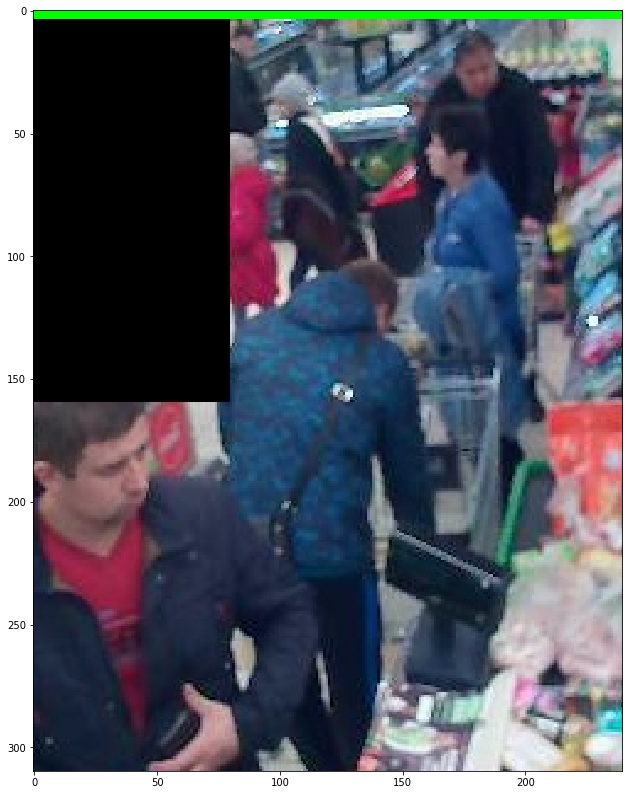

In [33]:
def run_inference_for_image_part_pcnt(image_tensor, sess, tensor_dict, 
                                 image, cutoff, p_ax0, p_ay0, p_ax1, p_ay1):
    h, w, c = image.shape
    max_x, max_y = w-1, h-1
    return run_inference_for_image_part(
                                image_tensor, sess, tensor_dict, 
                                image, cutoff, 
                                int(p_ax0*max_x), int(p_ay0*max_y), 
                                int(p_ax1*max_x), int(p_ay1*max_y))
def display_image_with_boxes(image, boxes, p_x0=0, p_y0=0, p_x1=1, p_y1=1):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    for x0, y0, x1, y1, score in boxes:
        image = cv2.rectangle(image, (x0, y0), (x1, y1), (0,255,0), 5)
    if p_x0 != 0 or p_y0 !=0 or p_x1 != 1 or p_y1 != 1:
        h, w, c = image.shape
        max_x, max_y = w-1, h-1
        image = cv2.rectangle(image, 
                              (int(p_x0*max_x), int(p_y0*max_y)), 
                              (int(p_x1*max_x), int(p_y1*max_y)), (0,0,255), 5)
    plt.figure(figsize=(14, 14))
    plt.imshow(image)
def run_inference_for_image_part(image_tensor, sess, tensor_dict, 
                                 image, cutoff, ax0, ay0, ax1, ay1):
    boxes = []
    im = image[ay0:ay1, ax0:ax1]
    h, w, c = im.shape
    output_dict = run_inference_for_single_image(im, image_tensor, sess, tensor_dict)
    for i in range(100):
        if output_dict['detection_scores'][i] < cutoff:
            break
        y0, x0, y1, x1, score = *output_dict['detection_boxes'][i], \
                                output_dict['detection_scores'][i]
        x0, y0, x1, y1, score = int(x0*w), int(y0*h), \
                                int(x1*w), int(y1*h), \
                                int(score * 100)
        boxes.append((x0+ax0, y0+ay0, x1+ax0, y1+ay0, score))
    return boxes    
def initialize_graph():
    ops = tf.get_default_graph().get_operations()
    all_tensor_names = {output.name
                        for op in ops
                        for output in op.outputs}
    tensor_dict = {}
    for key in ['num_detections', 'detection_boxes',
                'detection_scores', 'detection_classes',
                'detection_masks']:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
            tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
    image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')
    return image_tensor, tensor_dict
def run_inference_for_single_image(image, image_tensor, sess, tensor_dict):
    # Run inference
    def non_max_suppression_with_tf(boxes, scores,detection_classes, iou_threshold=0.5):
        non_max_idxs = tf.image.non_max_suppression(boxes, scores, 50, iou_threshold=iou_threshold)
        new_boxes = tf.cast(tf.gather(boxes, non_max_idxs), tf.int32)
        new_scores = tf.gather(scores, non_max_idxs)
        new_classes = tf.gather(detection_classes, non_max_idxs)

        return new_boxes.eval(), new_scores.eval(),new_classes.eval()
    expanded_dims = np.expand_dims(image, 0)
    output_dict = sess.run(tensor_dict, feed_dict={image_tensor: expanded_dims})
    
    # all outputs are float32 numpy arrays, so convert types as appropriate
    
    output_dict['num_detections'] = int(output_dict['num_detections'][0])
    output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
    output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
    output_dict['detection_scores'] = output_dict['detection_scores'][0]
    output_dict['detection_boxes'],output_dict['detection_scores'],output_dict['detection_classes']=non_max_suppression_with_tf(output_dict['detection_boxes'],output_dict['detection_scores'],output_dict['detection_classes'])
    return output_dict
# starting function for inference
def do_inference_and_display(file, cutoff, p_x0=0, p_y0=0, p_x1=1, p_y1=1):
    with detection_graph.as_default():
        with tf.Session() as sess:
            image_tensor, tensor_dict = initialize_graph()
            image = cv2.imread(f'{file}')
            h, w, c = image.shape
            boxes = run_inference_for_image_part_pcnt(
                image_tensor, sess, tensor_dict, image, cutoff, p_x0, p_y0, p_x1, p_y1)
            display_image_with_boxes(image, boxes, p_x0, p_y0, p_x1, p_y1)
do_inference_and_display(r"D:\Projects\Order_counting\data_3\624image_4_im1_tf7.jpg",0.5)


In [4]:
%%time
#Итоговый поиск tensorflow
import os
import pandas as pd
import cv2
import time
import numpy as np
from sklearn.metrics import mean_absolute_error
import imutils 
import tensorflow as tf
from imutils.object_detection  import non_max_suppression 
from imageai.Detection import ObjectDetection
from tqdm import tqdm_notebook
PATH_TO_LABELS = "D:\Projects\Order counting\mscoco_label_map.pbtxt"
base="D:\Projects\Order_counting\data"
PATH_TO_FROZEN_GRAPH =r'D:\Projects\Order_counting\faster_rcnn_inception_v2_coco_2018_01_28\frozen_inference_graph.pb'
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                  'num_detections', 'detection_boxes', 'detection_scores',
                  'detection_classes', 'detection_masks'
              ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[1], image.shape[2])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

          # Run inference
            output_dict = sess.run(tensor_dict,
                                 feed_dict={image_tensor: image})

          # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
              'detection_classes'][0].astype(np.int64)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict  

def prediction(image_path,h):
    image = cv2.imread(image_path)
    image=image[:310,180:420]
    image[:160,:80]=0
    image_np_expanded = np.expand_dims(image, axis=0)
    output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
    itog=[]
    for i in range(100):
        if output_dict['detection_scores'][i]<0.5:
            break
        if output_dict['detection_classes'][i]==1:
            itog.append(output_dict['detection_boxes'][i])
    return len(non_max_suppression(np.asarray(itog),overlapThresh=h))
def people_prediction(img_path,h):
    label=img_path.split('.')[0].split('_')[1]
    start_time=time.time()
    return img_path,label,prediction(os.path.join(base,img_path),h),time.time()-start_time
#print(os.listdir("D:\Projects\Order_counting\data"))
def result(h):
    a=os.listdir(base)
    itog=[]
    for i in a:
        itog.append(people_prediction(i,h))
    result=pd.DataFrame(itog,columns=['name','label','prediction','times'])
    result['label']=result['label'].astype(int)
    return [h,mean_absolute_error(result['label'],result['prediction']),
           mean_absolute_error(result['label'].loc[result['label']>4],result['prediction'].loc[result['label']>4]),
           (result['label']==result['prediction']).mean()]
import multiprocessing
inputs=[0.96,0.97,0.98,0.99,1]
res=[]
for h in tqdm_notebook(inputs):
    res.append(result(h))
data=pd.DataFrame(res,columns=['Overlap','средняя ошибка','средняя ошибка при большой очереди','процент верно предсказанных'])
data


Wall time: 1h 4min 31s


,Overlap,средняя ошибка,средняя ошибка при большой очереди,процент верно предсказанных
0,0.96,0.707692,1.80,0.502564
1,0.97,0.702564,1.76,0.507692
2,0.98,0.712821,1.76,0.492308
3,0.99,0.733333,1.72,0.471795
4,1.00,0.702564,1.44,0.482051


In [23]:
image = cv2.imread(r"D:\Projects\Order_counting\data1024\143image_1.jpg")
image=image[300:,450:1350]
image[:350,:350]=0
cv2.imshow("result", image)
cv2.waitKey(0)
cv2.destroyAllWindows()